In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt


In [132]:
def lin_approx(x,w):
    return np.matmul(w,x)

def lin_approx_grad(x,w):
    q = lin_approx(x,w)
    grad = np.repeat(np.transpose(x), q.shape[0], axis=0)
    return (q,grad)

def lin_sigmoid(x,w):
    return 1.0/(1.0 + np.exp(-np.matmul(w,x)))

def lin_sigmoid_grad(x,w):
    q = lin_approx(x,w)
    grad = np.matmul(q*(1.0-q),np.transpose(x))
    return (q,grad)

In [146]:
REWARD_I = 4

def SARSAnApprox(sequence, q_approx, q_grad, w, n, gamma, alpha):
    gamma_powered = [gamma**i for i in range(0,n+1)]
    sequence_iter = iter(sequence)
    for episode_i in range(50000):  
      try:
        step = next(sequence_iter)
        state, is_terminal, next_state, action, reward = step
        T = sys.maxsize
        t = 0
        history = [step]

        while True:
            if t < T:
                if is_terminal:
                    T = t+1
                    print("\rEpisode length is {:7}; tau={:7}".format(T,tau), end='', flush=True)
                else:
                    step = next(sequence_iter)
                    state, is_terminal, next_state, action, next_reward = step
                    history.append(step)

            tau = t-n+1
            if tau >= 0:
                G = np.sum( [gamma_powered[j]*history[tau+j][REWARD_I]
                             for j in range(0,min(n,T-tau))])
                if tau+n < T:
                    G = G + gamma_powered[n] * q_approx(state, action, w)
                Stau, istrm, next_tau, Atau, Rtau = history[tau]
                q,grad = q_grad(Stau, Atau, w)
                w[Atau] += alpha*(G - q)*grad

            if tau == T-1: break
            t += 1

      except StopIteration:
        print("\nSequence terminated.")
        break

    print("\nFinished.")

In [147]:
def tiling(value, low_bound, high_bound, pitch):
    n = int((high_bound-low_bound)/pitch + 1)
    i = int((value - low_bound)/pitch)
    return [x <= i+1 and x >= i-1 for x in range(n)]

In [ ]:
import gym
env_name = 'MountainCar-v0'
env = gym.make(env_name)
state_shape = env.env.observation_space.shape[0]
actions_num = env.env.action_space.n
state = env.reset()
next_state, reward, done, info = env.step(action)


### Mountain Car Problem Setup

In [148]:
def mc_getStartPosition():
    return (np.random.rand(1)[0]*0.2-0.6, 0.0)

REWARD = -1.0

def mc_getTransition(position, velocity, push):
    finished = False
    v = np.clip(velocity + 0.001*push - 0.0025*np.cos(3.0*position), -0.07, 0.07)
    p = position + v
    if p <= -1.2:
        p = -1.2
        v = 0.0
    elif p >= 0.5:
        p = 0.5
        finished = True
    return (p, v, finished, REWARD)

In [149]:
class SequenceGeneratorPlus:
    def __init__(self, getAction, getStartState, getTransition, episode_imax=1, steps_max=0,
                callBack=None, episode_maxlen=0):
        self.episode_imax = episode_imax
        self.get_action = getAction
        self.get_start_state = getStartState
        self.get_transition = getTransition
        self.steps_max = steps_max
        self.callback = callBack
        self.episode_maxlen = episode_maxlen

    def __iter__(self):
        self.episode_i=1
        self.state = None
        self.step_i = 0
        self.episode_step = 0
        return self

    def __next__(self):
        if self.episode_imax > 0 and self.episode_i > self.episode_imax or \
            self.steps_max > 0 and self.step_i > self.steps_max:
            raise StopIteration

        if self.state == None:
            self.state = self.get_start_state()
            self.episode_step = 0

        action = self.get_action(self.state)
        keep_state = self.state
        is_terminal, self.state, reward = self.get_transition(keep_state, action)
        
        if self.episode_maxlen > 0 and self.episode_step >= self.episode_maxlen:
            is_terminal = True

        if self.callback:
            self.callback(self, keep_state, is_terminal, self.state, action, reward)

        self.step_i += 1
        self.episode_i += int(is_terminal)
        self.episode_step += 1

        if is_terminal:
            self.state = None

        return keep_state, is_terminal, self.state, action, reward

### Run the learning

In [168]:
sys.path.append('..')
import SeqGen

def get_features(pos,vel):
    return np.float32([1.0] + tiling(pos, -1.2, 0.5, 0.2) + tiling(vel, -0.07, 0.06999, 0.02))

features_dim = len(get_features(.6, 0.01))
getFeatures = lambda k: get_features(k[0],k[1])
ACTION_FEATURES = [[1,0,0],[0,1,0],[0,0,1]]
actions_dim = len(ACTION_FEATURES)

class getActionValues:
    def __init__(self, w):
        self.w = w

    def __getitem__(self, state):
        x = get_features(state[0],state[1])
        return lin_approx(np.transpose(np.array([x])), w)

def tiling_lin_approx(state, action, w):
    x = get_features(state[0],state[1])
    return lin_approx(np.transpose(np.array([x])), w[action])[0]

def tiling_lin_approx_grad(state, action, w):
    x = get_features(state[0],state[1])
    q,grad = lin_approx_grad(np.transpose(np.array([x])), w[action])
    return q[0],grad[0]

w = (np.random.rand(actions_dim, features_dim) - 0.5) * 0.001
# Need for SeqGen.EpsilonGreedyPolicy
q_s_a_func = getActionValues(w)

def getStateTransition(s,a):
    p,v,f,r = mc_getTransition(s[0], s[1], a-1.0)
    return (f, (p,v), r)

In [169]:
sequence = SequenceGeneratorPlus(SeqGen.EpsilonGreedyPolicy(q_s_a_func, 0.1), 
                                  mc_getStartPosition,
                                  getStateTransition,
                                  100,
                                  episode_maxlen = 5500
                                 )

In [172]:
SARSAnApprox(sequence, tiling_lin_approx, tiling_lin_approx_grad, \
             w, 14, 0.99, 0.005)

Episode length is     139; tau=    124
Sequence terminated.

Finished.


### Draw -max(action_value_function)

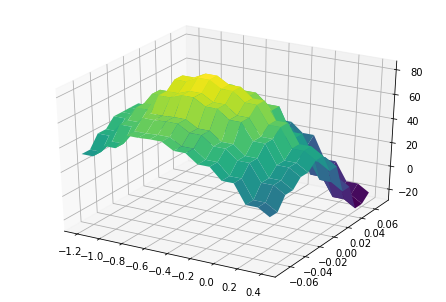

In [173]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(-1.2, 0.5, 0.1)
Y = np.arange(-0.07, 0.07, 0.01)
X, Y = np.meshgrid(X, Y)

it = zip(X.ravel(), Y.ravel())

Z = np.array([-np.max(q_s_a_func[s]) for s in it]).reshape(X.shape)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)

plt.show()

### Testing section

In [ ]:
gamma = 0.99
alpha = 0.01
n = 20

gamma_powered = [gamma**i for i in range(0,n+1)]
sequence_iter = iter(sequence)
for episode_i in range(50):
    try:
        step = next(sequence_iter)
        state, is_terminal, next_state, action, reward = step
        T = sys.maxsize
        t = 0
        history = [step]

        while True:
            if t < T:
                if is_terminal:
                    T = t+1
                    print("\rEpisode length is {:7}; tau={:7}".format(T,tau), end='', flush=True)
                else:
                    step = next(sequence_iter)
                    state, is_terminal, next_state, action, next_reward = step
                    history.append(step)

            tau = t-n+1
            if tau >= 0:
                G = np.sum( [gamma_powered[j]*history[tau+j][REWARD_I]
                             for j in range(0,min(n,T-tau))])
                if tau+n < T:
                    G = G + gamma_powered[n] * tiling_lin_approx(state, action, w)
                Stau, istrm, next_tau, Atau, Rtau = history[tau]
                q,grad = tiling_lin_approx_grad(Stau, Atau, w)
                w[Atau] += alpha*(G - q)*grad

            if tau == T-1: break
            t += 1

    except StopIteration:
        print("\nSequence terminated.")
        break

print("\nFinished.")

In [ ]:
tiling_lin_approx(Stau, Atau, w)

In [ ]:
s=(-.2, -0.02)
q_s_a_func[s], np.argmax(q_s_a_func[s])

In [ ]:
s=(.0001, 0.049)
q_s_a_func[s], np.argmax(q_s_a_func[s])